# Марковский процесс принятия решений для таксиста в Новинске

## Задание 1. Описание марковского процесса

описать марковский процесс для созданной среды:

- **Места пассажиров**. Всего существует 4 возможных места для пассажиров — A, B, C, D.
- **Пункты назначения**. Существует 4 возможных пункта назначения — a, b, c, d.
- Пассажир может находиться в любом из четырех мест и желать доехать до любого из четырех пунктов назначения.
- Таксист автоматически забирает пассажира, подъезжая к его месту.
- Для высадки пассажира в нужном месте таксисту необходимо выбрать соответствующее действие.
- Места A, B, C, D и a, b, c, d фиксированы.
- В начале эпизода случайным образом определяется пара (пассажир, место назначения).

### 1. Состояния (S):

- **Позиция таксиста**: координаты (x, y) на сетке N×N.
- **Статус пассажира**:
  - Если пассажир не в такси: его местоположение (A, B, C, D).  
  - Если пассажир в такси: значение `in_taxi`.  
- **Пункт назначения**: a, b, c, d (актуально, если пассажир в такси или ещё не подобран).  

> **Пример состояния**: `{(3, 2, A, b)}` — таксист в ячейке (3,2), пассажир ждет в точке A, назначение — b.


### 2. Действия (A):

- **Движение**: Вверх, Вниз, Влево, Вправо.  
- **Высадка пассажира** (специальное действие).

> **Пример действия**: A = `{↑, ↓, ←, →, dropoff}`


### 3. Награды (R):

- **За шаг**: -1 (штраф за задержку).  
- **Успешная высадка**: +20 (пассажир доставлен в правильный пункт).  
- **Неудачная высадка**: -10 (высадка в неправильном месте или без пассажира).  


### 4. Переходы (P):

- **Движение**:  
  - Таксист перемещается в выбранном направлении, если это возможно.  
  - Если движение направлено за край сетки, позиция не меняется.
  
- **Погрузка**
  - При входе в ячейку с пассажиром (A, B, C, D), пассажир автоматически подбирается (`in_taxi`).  

- **Высадка**:  
  - Если пассажир в такси и текущая позиция совпадает с пунктом назначения:  
    - Эпизод завершается с наградой +20.  
  - Иначе:  
    - Эпизод завершается с штрафом -10.  


### 5. Начальное состояние:
- Позиция таксиста: случайная ячейка сетки.  
- Пара (пассажир, пункт назначения): случайно выбирается из комбинаций A-D и a-d.  


### 6. Конечное состояние:
Эпизод завершается после действия **Высадка**.  


### 7. Дисконтирование:
Коэффициент дисконтирования γ = 0.9 (задача с конечным горизонтом).  





**Особенности:**
- Пассажир и назначение фиксированы в начале эпизода.  
- Высадка возможна только через специальное действие.  
- Среда детерминированная (переходы и награды предсказуемы).  


**Пример сценария:**  
1. Эпизод начинается с состояния: таксист в (1,1), пассажир в A, назначение — c.  
2. Таксист движется к A, подбирает пассажира (переход в `in_taxi`).  
3. Таксист едет к c, выполняет действие **Высадка** → успех, награда +20.  
4. Эпизод завершается.  


**Оптимальная стратегия:**  
Минимизировать время доставки:  
1. Кратчайший путь к пассажиру.  
2. Кратчайший путь к назначению.  
3. Высадка в правильной ячейке.

## Задание 2. Реализация итеративного алгоритма (Policy Iteration / Value Iteration)

Реализовать итеративный алгоритм для одной из постановок задачи и описанного МППР (марковского процесса принятия решений) из [репозитория](https://github.com/ZoyaV/transportation_bench).

**Вариант 1**. Построение маршрута перевоза одного пассажира (mdp_taxi_v1). Здесь предполагается, что построение стратегии для перевозки одного пассажира mdp основано на среде Taxi-v3.

**Вариант 2**. Определение порядка развоза пассажиров (mdp_taxi_v2). В данной постановке необходимо выбрать оптимальный порядок перевозки пассажиров, чтобы сэкономить топливо.

**Вариант 3**. Реализация кода, кодирующего МПП из задания 1, и предложение решения для этой постановки.

Для варианта 1 и варианта 2 mdp и среды уже готовы, основная задача — реализация алгоритма, решающего целевую задачу постановки.



In [1]:
# Импортируем импорты
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Определим параметры среды
N = 5  # размер сетки
GAMMA = 0.9  # коэффициент дисконтирования
THETA = 1e-4  # критерий сходимости

# Координаты точек посадки и высадки
pickup_locations = {
    'A': (0, 0),
    'B': (0, N-1),
    'C': (N-1, 0),
    'D': (N-1, N-1)
}
destinations = {
    'a': (1, 1),
    'b': (1, N-2),
    'c': (N-2, 1),
    'd': (N-2, N-2)
}

In [2]:
# Основная логика работы программы

ACTIONS = [0, 1, 2, 3, 4]  # 0-3: движения, 4: высадка
ACTION_NAMES = {0: "↑", 1: "↓", 2: "→", 3: "←", 4: "dropoff"}

class TaxiMDP:
    def __init__(self, N):
        self.N = N
        self.pickup_locations = pickup_locations
        self.destinations = destinations
        self.actions = ACTIONS

    def reset(self):
        """Генерирует начальное состояние"""
        taxi_row, taxi_col = np.random.randint(0, self.N, 2)
        passenger, destination = np.random.choice(list('ABCD')), np.random.choice(list('abcd'))
        return (taxi_row, taxi_col, passenger, destination)

    def is_terminal(self, state):
        return state is None

    def step(self, state, action):
        if state is None:
            return None, 0

        taxi_row, taxi_col, passenger, destination = state
        reward = -1  # Штраф за шаг по умолчанию

        # Обработка высадки
        if action == 4:
            dest_coord = self.destinations[destination]
            if passenger == 'in_taxi' and (taxi_row, taxi_col) == dest_coord:
                reward = 20
            else:
                reward = -10
            return None, reward

        # Обработка движения
        new_row, new_col = taxi_row, taxi_col
        if action == 0:  # North
            new_row = max(taxi_row-1, 0)
        elif action == 1:  # South
            new_row = min(taxi_row+1, self.N-1)
        elif action == 2:  # East
            new_col = min(taxi_col+1, self.N-1)
        elif action == 3:  # West
            new_col = max(taxi_col-1, 0)

        # Погрузка пассажира (только в его стартовой точке)
        new_passenger = passenger
        if passenger != 'in_taxi':
            pick_coord = self.pickup_locations[passenger]
            if (new_row, new_col) == pick_coord:
                new_passenger = 'in_taxi'

        new_state = (new_row, new_col, new_passenger, destination)
        return new_state, reward

    def get_all_states(self):
        """Генерирует все возможные состояния"""
        states = []
        for i in range(self.N):
            for j in range(self.N):
                for passenger in list('ABCD') + ['in_taxi']:
                    for dest in list('abcd'):
                        states.append((i, j, passenger, dest))
        return states



def value_iteration(env, gamma=GAMMA, theta=THETA):
    """Алгоритм итерации по стоимости"""
    states = env.get_all_states()
    V = defaultdict(float)
    policy = {}
    deltas = []

    iteration = 0
    while True:
        delta = 0
        for state in states:
            if state is None: continue
            v = V[state]
            max_value = -np.inf
            for a in ACTIONS:
                next_state, reward = env.step(state, a)
                value = reward
                if not env.is_terminal(next_state):
                    value += gamma * V[next_state]
                if value > max_value:
                    max_value = value
            V[state] = max_value
            delta = max(delta, abs(v - V[state]))
        iteration += 1
        deltas.append(delta)
        if delta < theta: break

    # Извлечение политики
    for state in states:
        if state is None: continue
        best_action = None
        max_value = -np.inf
        for a in ACTIONS:
            next_state, reward = env.step(state, a)
            value = reward
            if not env.is_terminal(next_state):
                value += gamma * V[next_state]
            if value > max_value:
                max_value = value
                best_action = a
        policy[state] = best_action

    return V, policy, iteration, deltas

def policy_iteration(env, gamma=GAMMA, theta=THETA):
    """Алгоритм итерации по политике"""
    states = env.get_all_states()
    policy = {s: np.random.choice(ACTIONS) for s in states if s is not None}
    V = defaultdict(float)
    
    iterations = 0
    while True:
        # Оценка политики
        while True:
            delta = 0
            for s in states:
                if s is None: continue
                v = V[s]
                a = policy[s]
                next_s, r = env.step(s, a)
                V[s] = r + (gamma * V[next_s] if not env.is_terminal(next_s) else 0)
                delta = max(delta, abs(v - V[s]))
            if delta < theta: break
        
        # Улучшение политики
        policy_stable = True
        for s in states:
            if s is None: continue
            old_a = policy[s]
            best_a = None
            max_value = -np.inf
            for a in ACTIONS:
                next_s, r = env.step(s, a)
                value = r + (gamma * V[next_s] if not env.is_terminal(next_s) else 0)
                if value > max_value:
                    max_value = value
                    best_a = a
            policy[s] = best_a
            if best_a != old_a:
                policy_stable = False
        iterations += 1
        if policy_stable: break
    
    return V, policy, iterations

## Задание 3. Демонстрация работы обученной стратегии

Реализовать инференс, демонстрирующий работу обученной стратегии на различных вариантах поля:

- Отрисуйте маршрут, по которому двигается агент.
- Покажите график, иллюстрирующий, как с итерациями меняется вознаграждение, которое основываясь на Value Function или Policy Function получает агент.

In [4]:
def visualize_route(env, policy, start_state=None, title="Маршрут такси"):
    """Визуализация маршрута агента по обученной политике"""
    state = start_state if start_state else env.reset()
    history = [state]
    total_reward = 0
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Создаем карту окружения
    grid = np.zeros((env.N, env.N))
    
    # Отмечаем специальные точки
    for loc in pickup_locations.values():
        grid[loc] = 0.3
    for dest in destinations.values():
        grid[dest] = 0.6
    
    # Отрисовка сетки
    ax.imshow(grid, cmap=ListedColormap(['white', 'lightgreen', 'lightblue']))

    # Аннотации для точек
    for label, coord in pickup_locations.items():
        ax.text(coord[1], coord[0], f'Pickup {label}', ha='center', va='center', backgroundcolor='white')
    for label, coord in destinations.items():
        ax.text(coord[1], coord[0], f'Dest {label}', ha='center', va='center', backgroundcolor='white')

    step_counter = 0
    action_history = []

    # Симуляция эпизода
    while True:
        action = policy[state]
        next_state, reward = env.step(state, action)
        total_reward += reward
        
        # Отрисовка движения
        taxi_pos = (state[0], state[1])
        next_taxi_pos = (next_state[0], next_state[1]) if next_state else None

        # Номер шага
        if next_taxi_pos:  
            dx = next_taxi_pos[1] - taxi_pos[1]
            dy = next_taxi_pos[0] - taxi_pos[0]

        # Смещаем текст относительно центра клетки
        offset_x = 0.35 * dx if dx != 0 else 0.25
        offset_y = -0.35 * dy if dy != 0 else -0.25
        
        # Выравнивание текста
        ha = 'left' if dx > 0 else 'right' if dx < 0 else 'center'
        va = 'bottom' if dy > 0 else 'top' if dy < 0 else 'center'

        ax.text(taxi_pos[1] + offset_x, 
                taxi_pos[0] + offset_y, 
                str(step_counter),
                ha=ha,
                va=va,
                fontsize=10, 
                color='red',
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.1'))

        # Стрелка движения
        if next_taxi_pos and taxi_pos != next_taxi_pos:
            dx = next_taxi_pos[1] - taxi_pos[1]
            dy = next_taxi_pos[0] - taxi_pos[0]
            ax.arrow(taxi_pos[1], taxi_pos[0], dx, dy, 
                     head_width=0.2, head_length=0.2, fc='red', ec='red')
        
        state = next_state
        if state is None:
            break
        history.append(state)

        action_history.append(ACTION_NAMES[action])
        state = next_state
        if state is None:
            break
        history.append(state)

        step_counter += 1
    
    # Построение графика
    ax.set_title(f"{title}\nШагов: {step_counter} Награда: {total_reward}\nДействия: {', '.join(action_history)}")
    ax.set_xticks(np.arange(-0.5, env.N, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, env.N, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    plt.show()


def plot_reward_dynamics(env, policy, num_episodes=50):
    """График изменения вознаграждения"""
    episode_rewards = []
    
    for _ in range(num_episodes):
        state = env.reset()
        total_reward = 0
        while True:
            action = policy[state]
            next_state, reward = env.step(state, action)
            total_reward += reward
            state = next_state
            if state is None:
                break
        episode_rewards.append(total_reward)
    
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards, marker='o')
    plt.xlabel('Номер эпизода')
    plt.ylabel('Общее вознаграждение')
    plt.title('Динамика вознаграждения по эпизодам')
    plt.grid(True)
    plt.show()


def plot_value_iteration(convergence_deltas):
    """График Сходимости Value Iteration"""
    plt.figure(figsize=(10,5))
    plt.plot(convergence_deltas, marker='o')
    plt.title("Сходимость Value Iteration")
    plt.xlabel("Итерации")
    plt.ylabel("Максимальное изменение значения")
    plt.grid(True)
    plt.show()

Пример 1: Случайное начальное состояние


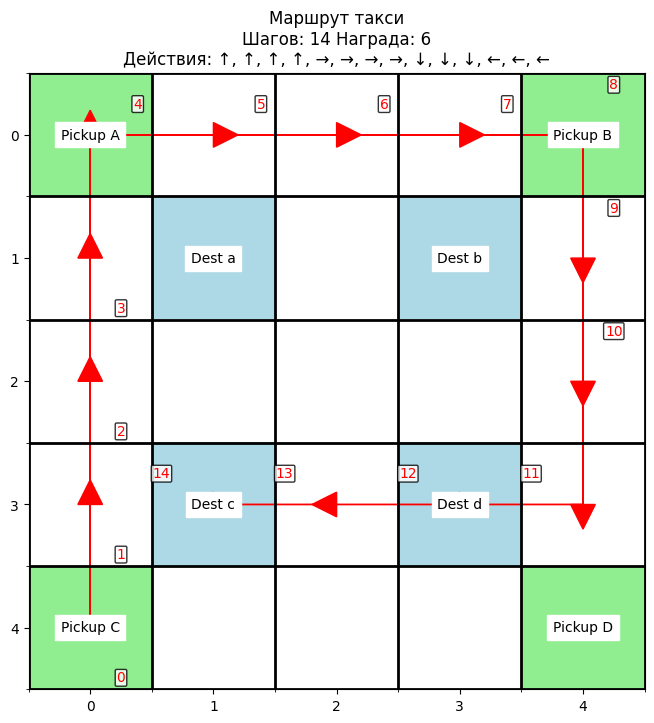


Пример 2: Сложный маршрут (3,2,C,d)


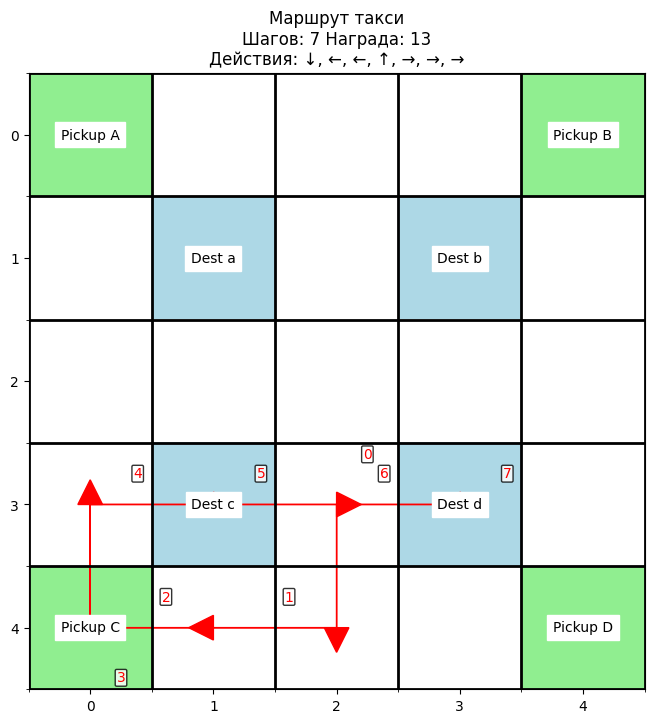


Пример 3: Попытка высадки без пассажира


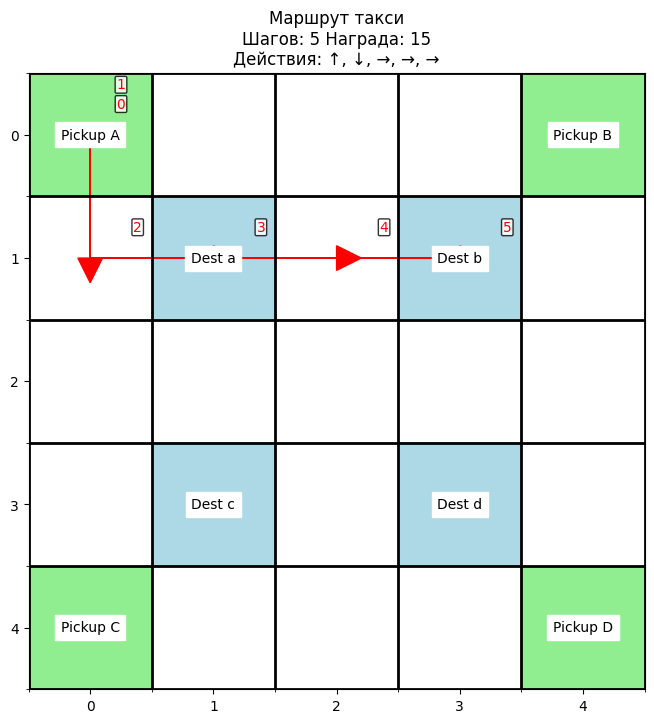

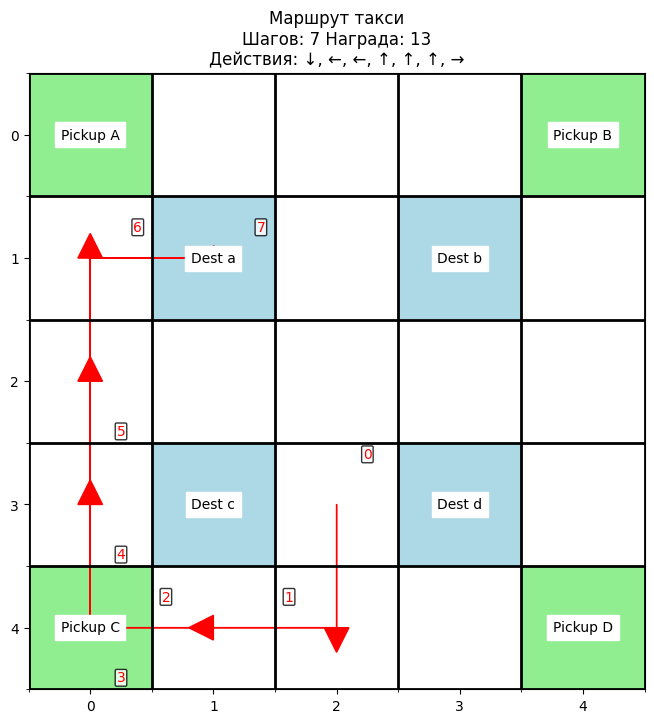

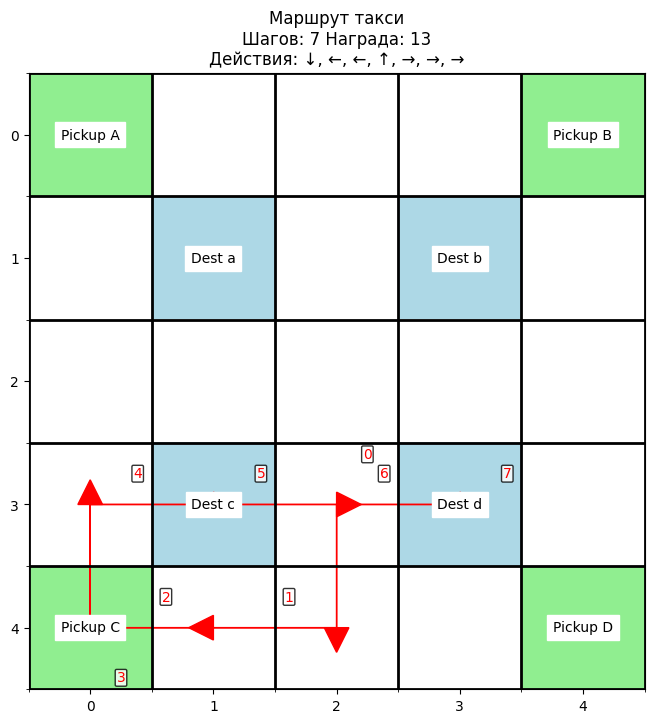

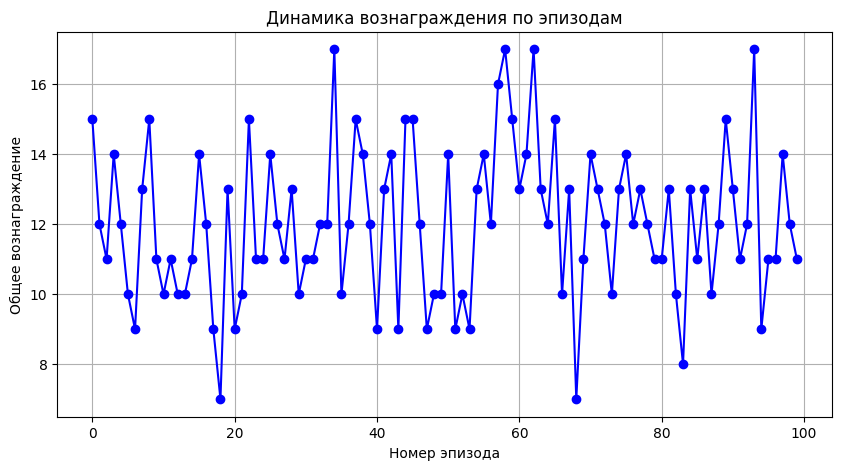

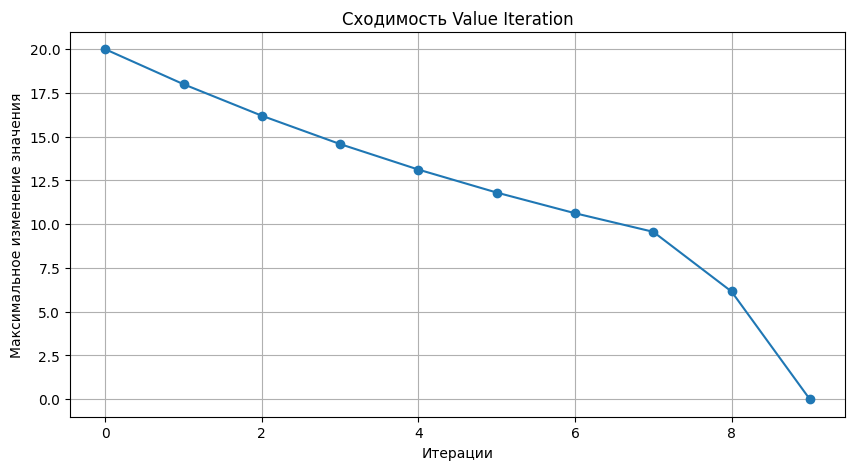

In [5]:
env = TaxiMDP(N)

# Обучаем политику
V_vi, policy_vi, _, convergence_deltas = value_iteration(env)

# Пример 1: Случайное начальное состояние
visualize_route(env, policy_vi, title="Пример 1: Случайное начальное состояние")

# Пример 2: Простой маршрут
test_case = (2, 2, 'A', 'a')
visualize_route(env, policy_vi, start_state=test_case, title="Пример 2: Простой маршрут (2,2,A,a)")

# Пример 3: Сложный маршрут
test_case = (3, 2, 'C', 'b')
visualize_route(env, policy_vi, start_state=test_case, title="Пример 3: Сложный маршрут (3,2,C,b)")

# Пример 4: Появление такси в точке погрузки
error_case = (4, 4, 'D', 'd')
visualize_route(env, policy_vi, start_state=error_case, title="Пример 4: Появление такси в точке погрузки (0,0,D,d)")

# График вознаграждения
plot_reward_dynamics(env, policy_vi, num_episodes=100)

# График Сходимости Value Iteration
plot_value_iteration(convergence_deltas)


## Критерии оценивания

Задание оценивается по следующим критериям:

- Корректность описания МППР (учтены все комбинации состояний, для каждого состояния определены возможные действия, вероятности переходов корректно установлены, награды за действия и переходы четко определены) — 3 балла.
- Код обучения запускается без ошибок — 3 балла.
- Визуализация результатов решения (например, отрисовка полученной стратегии на одном варианте поля) — 2 балла.
- Графики, демонстрирующие, что алгоритм обучается (например, как меняется значение V какого-то из состояний) — 2 балла.